# Training a VAE on MNIST
Enabling and testing the GPU

First, you'll need to enable GPUs for the notebook:

    Navigate to Edit→Notebook Settings
    select GPU from the Hardware Accelerator drop-down
    
You can check if the GPU works with nvidia-smi.


## Data loading
Let's import some libraries and load the MNIST dataset.

In [ ]:
# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import IPython.display
import numpy as np

bs = 100
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)


## Architecture specification

You can use the following encoder (don't forget that in a VAE the decoder has two heads, for the mean and the variance):
```
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc31): Linear(in_features=256, out_features=2, bias=True)
  (fc32): Linear(in_features=256, out_features=2, bias=True)
```
and this decoder:
```
  (fc4): Linear(in_features=2, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=512, bias=True)
  (fc6): Linear(in_features=512, out_features=784, bias=True)
```
Then, you need to complete the forward function. You can use Relu activations for every layers except for the heads that can reach negative values. Concerning the decoder head, you can use sigmoid to obtain values in [0,1].

Here we consider a latent space of dimension 2 but is could be any *zdim* dimension.

In [ ]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()
        
        # encoder part
        self.fc1 = # ...

        # decoder part
        self.fc4 = # ...


    def encoder(self, x):
        # ...
        return  # returns mu, log_var
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std) # std is used only for its dimensions
        return # ... return z sample
        
    def decoder(self, z):
        # ...
        return # ...


    def forward(self, x):
        mu, log_var = # ...
        z = self.sampling(mu, log_var)
        image_rec= # ...
        return image_rec, mu, log_var


## Loss function
The total loss of the VAE is composed of two terms: a reconstruction term and the KL divergence with the Prior. The KL divergence between two gaussians is given by:

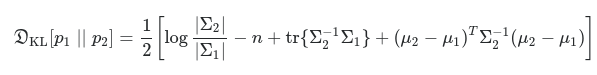

Assuming a unit gaussian as prior, we obtain a very simple equation that will help you to implement it in pytorch:

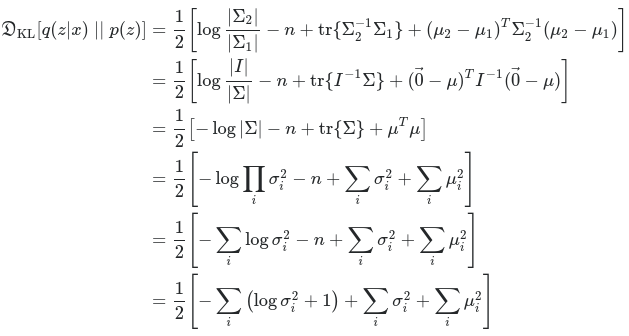

Note that, in these equations sigma denotes the standard deviation while the encoder network ouputs the log of the variance.  

In [ ]:
# build model
vae = VAE(x_dim=784, h_dim1= 512, h_dim2=256, z_dim=2)
if torch.cuda.is_available():
    vae.cuda()
optimizer = optim.Adam(vae.parameters())

# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    RecLoss = # ...
    KLDLoss = # ...
    return RecLoss + KLDLoss


## Training step
In this cell, we define the function that performs training on one epoch. We recommend to debug it using the "main loop" cell later in the page.

In [ ]:
def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.cuda()
        optimizer.zero_grad()
        
        # ...
        loss = # ...
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

## Visualization:
We provide some visualization functions:

In [ ]:

# Plot the loss from each batch
def plotLoss(epoch):
    plt.figure(figsize=(10, 8))
    plt.plot(dLosses, label='Discriminitive loss')
    plt.plot(gLosses, label='Generative loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('gan_loss_epoch_%d.png' % epoch)

# Create a wall of generated MNIST images
def plotGeneratedImages(generatedImages,dim=(10, 10), figsize=(10, 10)):
    generatedImages=generatedImages.cpu().numpy()
    print(generatedImages.shape)
    plt.figure(figsize=figsize)
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(np.squeeze(generatedImages[i]), interpolation='nearest', cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image_epoch_%d.png' % epoch)
    IPython.display.display(IPython.display.Image(data=('gan_generated_image_epoch_%d.png' % epoch)))


## Test
Complete the test function that generate new sample from latent space samples. 

In [ ]:
def test():
    vae.eval()
    test_loss= 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.cuda()
            recon, mu, log_var = # ...
            
            # sum up batch loss
            test_loss += # ...
        
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))
    with torch.no_grad():
      z = torch.randn(64, 2).cuda()
      generated = # ...
      plotGeneratedImages(generated.view(generated.size(0), 1, 28, 28))
      #save_image(sample.view(64, 1, 28, 28), '.sample_' + '.png')



## Main loop

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 1 [0/60000 (0%)]	Loss: 544.157109
Train Epoch: 1 [10000/60000 (17%)]	Loss: 192.633262
Train Epoch: 1 [20000/60000 (33%)]	Loss: 179.115664
Train Epoch: 1 [30000/60000 (50%)]	Loss: 167.725820
Train Epoch: 1 [40000/60000 (67%)]	Loss: 173.728730
Train Epoch: 1 [50000/60000 (83%)]	Loss: 162.115186
====> Epoch: 1 Average loss: 179.4358
====> Test set loss: 161.0389
(64, 1, 28, 28)


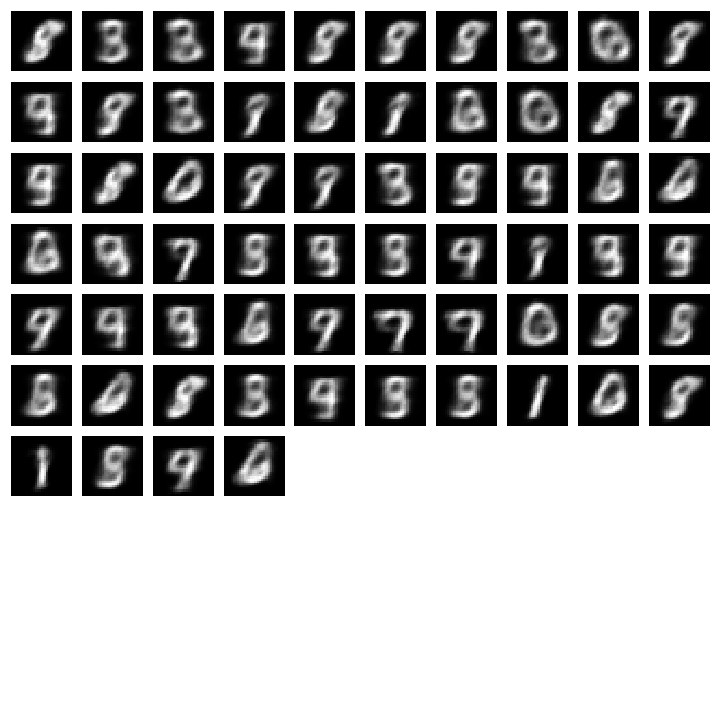

Train Epoch: 2 [0/60000 (0%)]	Loss: 160.225459
Train Epoch: 2 [10000/60000 (17%)]	Loss: 159.847451
Train Epoch: 2 [20000/60000 (33%)]	Loss: 158.530566
Train Epoch: 2 [30000/60000 (50%)]	Loss: 153.080000
Train Epoch: 2 [40000/60000 (67%)]	Loss: 149.061201
Train Epoch: 2 [50000/60000 (83%)]	Loss: 154.350586
====> Epoch: 2 Average loss: 157.2676
====> Test set loss: 155.1937
(64, 1, 28, 28)


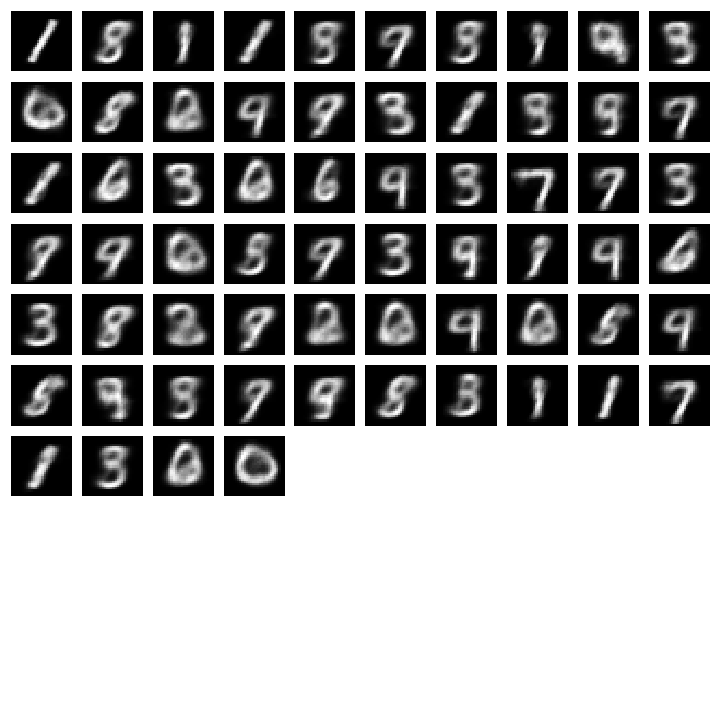

Train Epoch: 3 [0/60000 (0%)]	Loss: 148.014717
Train Epoch: 3 [10000/60000 (17%)]	Loss: 154.895078
Train Epoch: 3 [20000/60000 (33%)]	Loss: 161.122607
Train Epoch: 3 [30000/60000 (50%)]	Loss: 159.476631
Train Epoch: 3 [40000/60000 (67%)]	Loss: 152.253652
Train Epoch: 3 [50000/60000 (83%)]	Loss: 156.165469
====> Epoch: 3 Average loss: 152.4705
====> Test set loss: 150.9806
(64, 1, 28, 28)


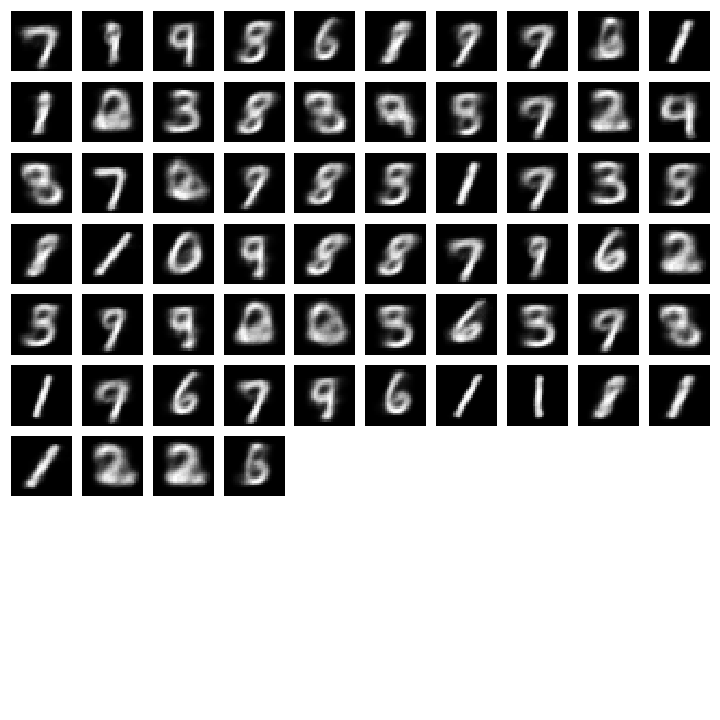

Train Epoch: 4 [0/60000 (0%)]	Loss: 151.605117
Train Epoch: 4 [10000/60000 (17%)]	Loss: 151.510742
Train Epoch: 4 [20000/60000 (33%)]	Loss: 148.008877
Train Epoch: 4 [30000/60000 (50%)]	Loss: 160.719453
Train Epoch: 4 [40000/60000 (67%)]	Loss: 144.816113
Train Epoch: 4 [50000/60000 (83%)]	Loss: 143.843330
====> Epoch: 4 Average loss: 149.6684
====> Test set loss: 149.9909
(64, 1, 28, 28)


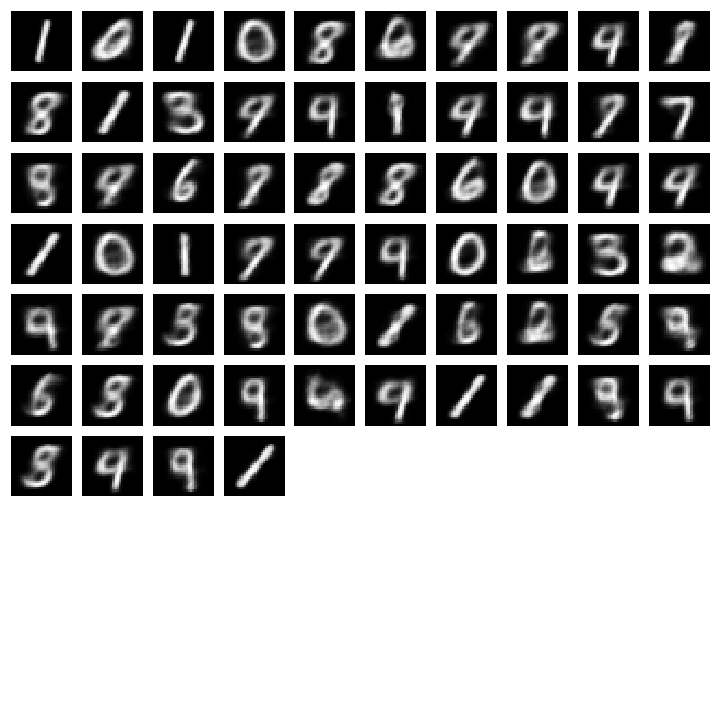

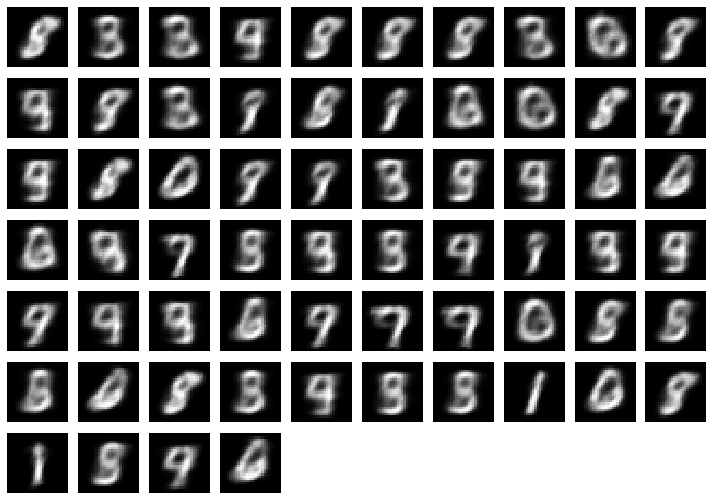

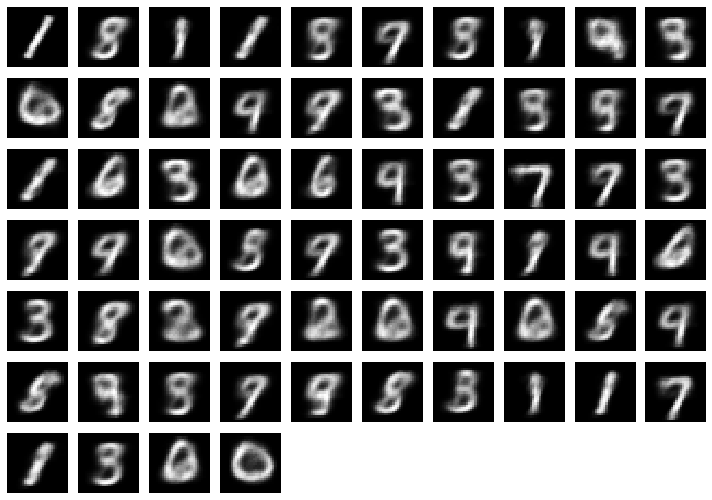

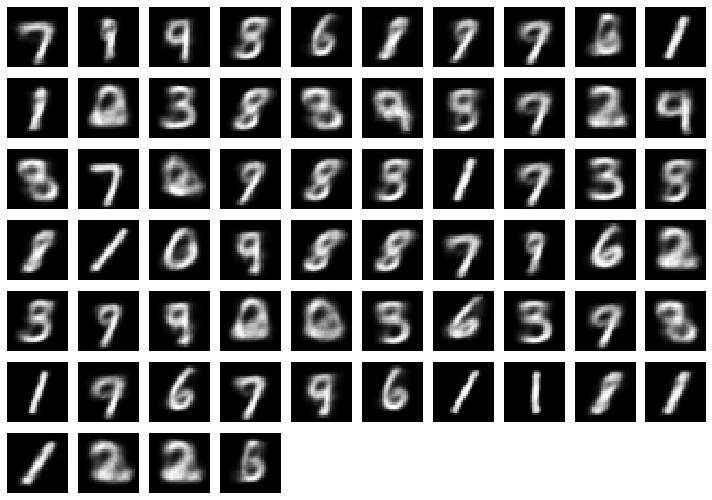

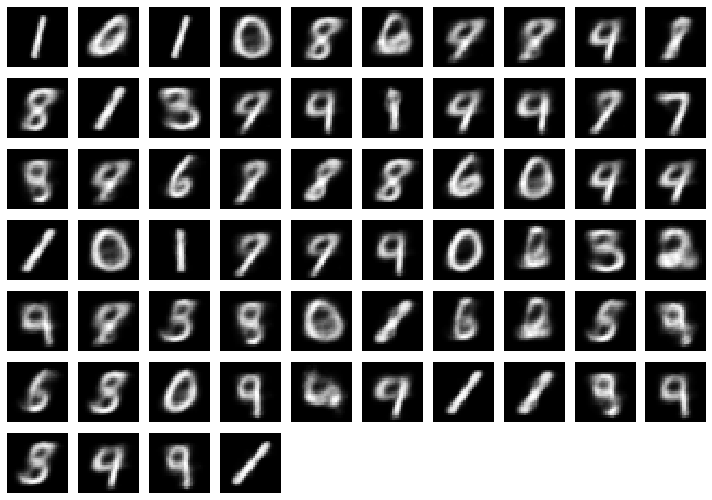

In [ ]:

for epoch in range(1, 5):
    train(epoch)
test()
    

## Bonus 1: Interpolation
Sample two latent vectors z1 and z2 and generate the corresponding images. Then, generate 10 intermediate images by performing linear interpolation in the latent space between the z1 and z2.

In [ ]:
# ...

## Bonus 2: Visualization
Generate a 10x10 mosaic by sampling *z* over a regulargrid in [-1,1]x[-1,1]. What do you observe? 


In [ ]:
# ...